## Кастомная метрика семантической насыщенности текста IDF-80.
----------

**Краткое содержание:** В рамках поставленной задачи было необходимо разработать метрику для оценки семантической насыщенности текста, в частности отзывов на книги. Для решения задачи был выбран и предобработан датасет. Также была придумана своя кастомная метрика, не основанная на глубоком обучении и предполагающая unsupervised подход, что делает её масштабируемой и работоспособной в условиях отсутствия разметки. 

### Импорт библиотек и выбор датасета

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

import pymorphy2
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tqdm.auto import tqdm
tqdm.pandas()

В качестве набора данных был выбран популярный датасет с обзором на книги от Амазона. Его можно и нужно скачать для запуска ноутбука по [ссылке](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews). Датасет содержит довольно большое количество информации о книге, но нам понадобится только review/summary и review/text - краткий и развёрнутый комментарий.

In [23]:
df = pd.read_csv("Books_rating.csv")

In [24]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


Оставим только нужные столбцы, удалим дубликаты и пропуски.

In [25]:
df = df[["review/summary", "review/text"]]
df = df.dropna()
df = df.drop_duplicates()

In [26]:
df.head()

,review/summary,review/text
0,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [27]:
print("размер датасета:", len(df))

размер датасета: 2067956


### Идея подхода для оценки насыщенности текста.

Метрика по-своей сути не должна учитывать размер текста, а должна основываться на его семантическом содержании. Также модель для оценки содержательности отзыва должна быть unsupervised learning, в случае, если у нас нет разметки с содержательностью комментария (т.к. часто это довольно проблематично оценить). Ну и метрика должна быть интерпретируемой, соотвественно, использование подхода "черного ящика" - не лучшая идея.  

В используемом наборе данных мы имеем полный и краткий текст комментария. Будем считать, что краткий комментарий всегда является семантически более насыщенным, чем полный (выше уровень смысловой нагрузки на одно слово). Будем использовать это для валидации: значение нашей метрики для насыщенного отзыва всегда должно быть выше, чем для развернутого.

Также довольно очевидно, что распространённые слова редко несут высокую семантическую нагрузку. Высокое значение метрики должно быть у предложений, в которых мало распространённых стилистически нейтральных и бесполезных слов. Самая очевидная гипотеза в таком случае - использование tf-idf: отношение частоты встречи слова в тексте, умноженное на логорифм частоты встречи слова во всём корпусе. Скорее всего, в текстовом документе с высокой семантической насыщенностью, частоты слов должно быть примерно одинаковы: каждое слово будет иметь одинаковую статистическую характеристику. Большое количество слов с низким tf-idf говорит о плохой интерпретируемости текста, а большое количество слов с высоким tf-idf говорит о наличие шума, не несущего уникальной информации в отзыве.

Отклонение частот слов в предложении будет считать как отношение 80% перцентили распределения частот в предложении к медиане частот в предложении. Это более интерпретируемо чем, например, средне-квадратичное отклонение, а также позволяет сделать нам фиксированный диапазон метрики от 0 до 100%.

### Реализация

Для начала лемматизируем текст и удалим стоп-слова. Обучим корпус tf-idf и на коротких комментариях, и на полных.

In [28]:
lemmatizer = WordNetLemmatizer()
lemmizer_func = lambda x: lemmatizer.lemmatize(x)

stopwords = stopwords.words("english")

In [29]:
def text_normalizing(texts, lemmatizer, stopwords=[]):
    """
    Function for cleaning and lemmatization texts.
    Args:
        -texts: collection of texts;
        -lemmatizer: callable object, which input text and return lemmatized text;
        -stopwords: list of words for dropping.
    Return normalized texts. 
    """
    texts = pd.Series(texts).astype(str)
    texts = texts.map(lambda x: x.replace("\n", " "))
    texts = texts.map(lambda x: re.sub('[0-9:,\.!?()-/+*;•$&%]', '', x.lower()))
    texts = texts.progress_map(lambda x: " ".join([lemmatizer(word) for word in x.split() if word not in stopwords]))
    return texts

In [30]:
corpus = text_normalizing(pd.concat([df["review/text"], df["review/summary"]], axis=0), lemmizer_func, stopwords)

  0%|          | 0/4135912 [00:00<?, ?it/s]

Обучим tf-idf векторизатор.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True).fit(corpus)

In [43]:
def idf80_saturation(vector_text):
    v = vector_text.toarray()[0]
    v = v[v != 0]
    if len(v) == 0:
        return 1
    return np.percentile(v, 0.8) / np.median(v)

### Оценим результаты работы

Будем тестировать на первых 40к сэмплах, чтобы сэкономить время.

In [33]:
df = df.iloc[:40000]
df["review/text"] = text_normalizing(df["review/text"], lemmizer_func, stopwords)
df["review/summary"] = text_normalizing(df["review/summary"], lemmizer_func, stopwords)

vector_text = vectorizer.transform(df["review/text"])
vector_small_text = vectorizer.transform(df["review/summary"])

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

На это уйдёт какое-то время.

In [47]:
idf80_full_texts = []
idf80_small_texts = []

for i in tqdm(range(0, len(df))):
    idf80_full_texts.append(idf80_saturation(vector_text[i]))
    idf80_small_texts.append(idf80_saturation(vector_small_text[i]))

  0%|          | 0/40000 [00:00<?, ?it/s]

Посмотрим, как выглядит распределение семантической насыщенности полных описаний.

<Axes: ylabel='Count'>

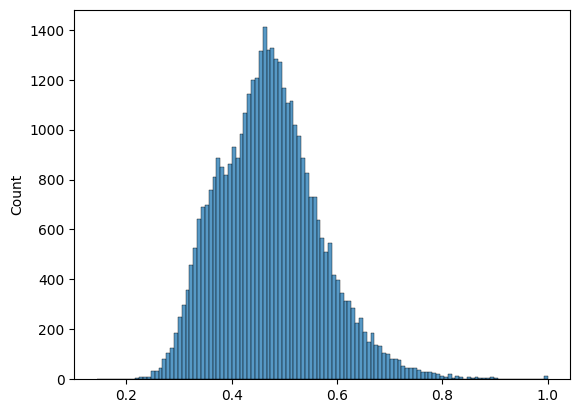

In [48]:
sns.histplot(idf80_full_texts)

Метрика для краткого отзыва в среднем в два раза больше, чем для полного. Это может говорить о том, что метрика в целом работает адекватно и, главное, интерпретируемо.

<Axes: ylabel='Count'>

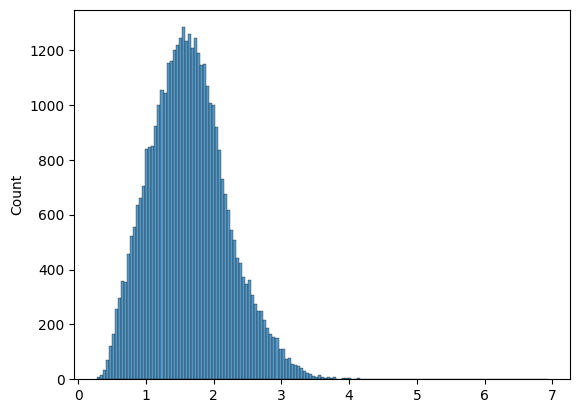

In [51]:
sns.histplot(np.array(idf80_small_texts) / np.array(idf80_full_texts))

### Как можно улучшить?

Основным недостатком использования глубокого обучения стало бы понижение интерпретируемости метрики в замен на более высокой качество и гибкость. Но интерпретируемость можно получить и с методами глубокого обучения: например, обучить линейный attention-слой оценивать вес каждого слова, а затем использовать метод, применённый к tf-idf частотам в ноутбуке. Благодаря такому подходу мы сможем понимать, какие слова имеют большую насыщенность, а какие меньшую.